# Import des librairies + paramètres

In [1]:
import warnings; warnings.simplefilter('ignore')
import P4_toolbox        as p4

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns

# pandas settings
pd.set_option('display.max_row', 110)
pd.set_option('display.max_column', 110)

# to show and store figures in the notebook
%matplotlib inline

# Nettoyage des données : création de transactions_original.csv

In [2]:
# loading datasets
transactions = pd.read_csv('./dataset/transactions.csv')
customers    = pd.read_csv('./dataset/customers.csv')
products     = pd.read_csv('./dataset/products.csv')
    
# cleaning part before merging part

# id 0_2245 : categ_0 median imputation
products.loc[products.shape[0]] = ['0_2245',9.99,0]

# to drop testing rows
transactions = transactions[transactions['session_id'] != 's_0']

    
# merging part

""" to check for duplicates on primary keys
products[products.duplicated('id_prod')]
customers[customers.duplicated('client_id')]
"""

transactions = transactions.merge(products)
transactions = transactions.merge(customers)
    
# cleaning part after merging part

# from birth_date to age
max_date_year = int(transactions['date'].str[0:4].max())
transactions['birth'] = max_date_year - transactions['birth']
transactions['birth'] = transactions['birth'].astype('int')

# from categorical to boolean
transactions['sex'] = transactions['sex'].map({'m' : 1,'f' : 0})
transactions['sex'] = transactions['sex'].astype('bool')

# categ : from number to string
transactions['categ'] = transactions['categ'].astype('str')
transactions['categ'] = 'c_' + transactions['categ']

# outliers : 4 big customers
outliers_customers_list = ['c_1609', 'c_3454', 'c_4958', 'c_6714']
row_indexer = transactions[transactions['client_id'].isin(outliers_customers_list)].index
outliers = transactions[transactions['client_id'].isin(outliers_customers_list)]
transactions = transactions.drop(index=row_indexer)

# outliers : 18 year's old age class
outliers = pd.concat([outliers, transactions[transactions['birth']==18]])
row_indexer = transactions[transactions['birth']==18].index
transactions = transactions.drop(index=row_indexer)

# customers[customers['average_basket_size']==10]
outliers = pd.concat([outliers, transactions[transactions['client_id']=='c_317']])
row_indexer = transactions[transactions['client_id']=='c_317'].index
transactions = transactions.drop(index=row_indexer)

# to rename columns for a better understanding
transactions.rename(columns = {'session_id' : 'id_sale',
                               'client_id'  : 'id_customer',
                               'birth'      : 'age',
                               'sex'        : 'is_male'},
                        inplace = True)


transactions.sort_values(by='date', inplace = True)
transactions.to_csv('./dataset/transactions_original.csv', index = False)
outliers.to_csv('./dataset/outliers.csv', index=False)

In [3]:
# id 0_2245 : categ_0 median
transactions[transactions['categ']=='c_0']['price'].median()

9.99

# Nettoyage des données : création de transactions_normalized.csv

## Méthode d'exploration pour prise de décision : exemple
Avant traitement : on regarde la forme de la courbe des fréquences et les statistiques univariées. On regarde aussi ce que donne classiquement le graphique boite à moustache.

        price
count  417.00
mean    27.00
std     17.01
min      2.00
25%     13.04
50%     24.03
75%     37.12
max     80.99


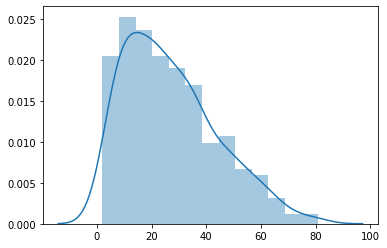

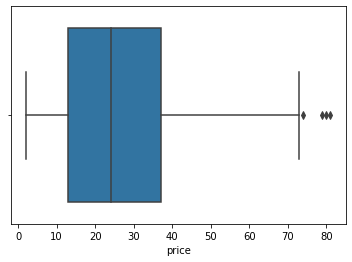

In [4]:
p4.frequences_graph_stats('price', transactions[transactions['categ'] == 'c_1'])

Après traitement : on cherche une valeur limite avec taux de perte acceptable. On a fixé un seuil arbitraire de perte de données de 5%

        price
count  257.00
mean    15.87
std      7.62
min      2.00
25%      9.22
50%     15.81
75%     22.23
max     29.99


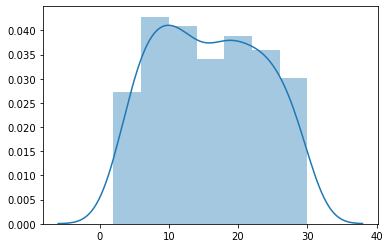

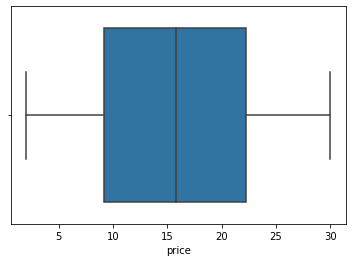

In [5]:
categ_1 = transactions[transactions['categ'] == 'c_1'].copy()
categ_1 = categ_1[categ_1['price'] <= 30]
 
p4.frequences_graph_stats('price', categ_1)

Vérification de l'impact : pourcentage de perte

In [6]:
categ_1 = transactions[transactions['categ'] == 'c_1'].copy()
p4.loss_ratio('price', categ_1, transactions, max_value=30)

% intra loss   0.0377
% global loss  0.0123


## Variable price

In [7]:
# shapiro test before dropping
p4.shapiro_ratio_categ_global('categ', 'price', transactions)

c_0 0.96
c_1 0.89
c_2 0.71
global 0.55


### Exploration des valeurs limites avec le graphique des fréquences + statistiques univariées 
fonction utilisée : p4.fequences_graph_stats()

In [8]:
# dropping values to have a better 'normal' variable
vector_name = 'price'

categ_0 = transactions[transactions['categ'] == 'c_0'].copy()
categ_1 = transactions[transactions['categ'] == 'c_1'].copy()
categ_2 = transactions[transactions['categ'] == 'c_2'].copy()

p4.drop_values(vector_name, categ_0, transactions, min_value=5, max_value=20)
p4.drop_values(vector_name, categ_1, transactions, min_value=10, max_value=30)
p4.drop_values(vector_name, categ_2, transactions, min_value=0, max_value=90)

In [9]:
# shapiro test after dropping
p4.shapiro_ratio_categ_global('categ', 'price', transactions)

c_0 0.96
c_1 0.96
c_2 0.98
global 0.72


## Variable age

In [10]:
# shapiro test before dropping
p4.shapiro_ratio_categ_global('categ', 'age', transactions)

c_0 0.92
c_1 0.99
c_2 0.64
global 0.96


### Exploration des valeurs limites avec le graphique des fréquences + statistiques univariées 
fonction utilisée : p4.fequences_graph_stats()

In [11]:
# dropping values to have a better 'normal' variable
vector_name = 'age'

categ_0 = transactions[transactions['categ'] == 'c_0'].copy()
categ_1 = transactions[transactions['categ'] == 'c_1'].copy()
categ_2 = transactions[transactions['categ'] == 'c_2'].copy()

p4.drop_values(vector_name, categ_0, transactions, min_value=18, max_value=65)
p4.drop_values(vector_name, categ_1, transactions, min_value=18, max_value=65)
p4.drop_values(vector_name, categ_2, transactions, min_value=18, max_value=35)

In [12]:
# shapiro test after dropping
p4.shapiro_ratio_categ_global('categ', 'age', transactions)

c_0 0.98
c_1 0.98
c_2 0.95
global 0.99


# Sauvegarde du preprocessing

In [13]:
transactions.to_csv('./dataset/transactions_normalized.csv', index=False)

## Création du dataframe customers

**Regroupe les caractéristiques des clients**

1. **id_customer** : clef primaire (unique non nul)
2. **is_male** : valeur binaire 1 pour homme et 0 pour femme.
3. **age** : age du client
4. **total_buy** : montant total des achats
5. **average_basket_size** : la taille du panier moyen en quantité de produits
6. **month_buy_rate** : quantité d'achats par mois
7. **age_segment** : tranche d'âge du client


## stucture de base : customers_template
ce dataframe va servir à construire les différentes features pour arriver au dataframe final.

In [14]:
transactions = pd.read_csv('./dataset/transactions_normalized.csv', index_col = 'date', parse_dates = True)
customers_template = transactions[['id_customer','is_male','age','price','id_sale', 'categ']].copy()

### total_buy

In [15]:
total_buy = customers_template[['id_customer','price']].groupby('id_customer').sum()
total_buy = total_buy.round().astype('int')
total_buy.columns = ['total_buy']

### average_basket_size

In [16]:
# to select useful columns
average_basket_size = customers_template[['id_customer','id_sale']].copy()

# to create a quantity column
average_basket_size['quantity'] = 1
average_basket_size = average_basket_size.groupby(['id_sale','id_customer']).sum().reset_index()

# to mean quantity
average_basket_size = average_basket_size[['id_customer','quantity']].groupby('id_customer').mean()

# to type into integer
average_basket_size = average_basket_size.round().astype('int')
average_basket_size.columns = ['average_basket_size']

### month_buy_rate

In [17]:
# to select useful columns
month_buy_rate = customers_template[['id_customer','id_sale']].copy()

# to compute month's number
nb_month = month_buy_rate.resample('M').sum().shape[0]

# to compute sales quantity by id_customer
month_buy_rate = month_buy_rate.groupby('id_customer').count()
month_buy_rate /= nb_month

# to type into integer
month_buy_rate = month_buy_rate.round().astype('int')
month_buy_rate.columns = ['month_buy_rate']

### age_segment

In [18]:
# to select useful columns
age_segment = customers_template[['id_customer','age']].drop_duplicates()
age_segment = age_segment.set_index('id_customer')

# to classify ages
age_segment.loc[(age_segment['age'] <= 30),'age_segment'] = '18 - 30'

age_segment.loc[(age_segment['age'] >= 31) &
                (age_segment['age'] <= 50),'age_segment'] = '31 - 50'

age_segment.loc[(age_segment['age'] >= 51),'age_segment'] = '51 +'

# to drop template vector
age_segment = age_segment.drop('age', axis=1)

### Dataframe customers

In [19]:
# to select useful columns
customers = transactions[['id_customer','is_male','age']].drop_duplicates().copy()
customers = customers.set_index('id_customer')

# to merge all features
customers = customers.merge(total_buy, left_index=True, right_index=True)
customers = customers.merge(average_basket_size, left_index=True, right_index=True)
customers = customers.merge(month_buy_rate, left_index=True, right_index=True)
customers = customers.merge(age_segment, left_index=True, right_index=True)

# to save dataframe
columns_order = ['is_male',
                 'age',
                 'age_segment', 
                 'total_buy',
                 'month_buy_rate', 
                 'average_basket_size']

customers = customers[columns_order]
customers.to_csv('./dataset/customers_preprocessed.csv')

## Déterminer la segmentation des ages : visualisation graphique

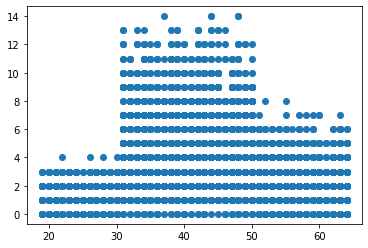

In [20]:
plt.scatter(customers['age'], customers['month_buy_rate']);

### Vérifier avec k-means : déterminer le nombre de clusters optimisés

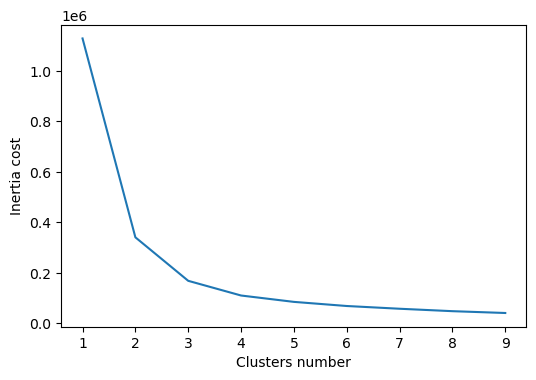

In [21]:
p4.elbow_method_graph('age', 'month_buy_rate', customers, 10)

### On choisit 3 clusters avec la lecture du graphique précédent

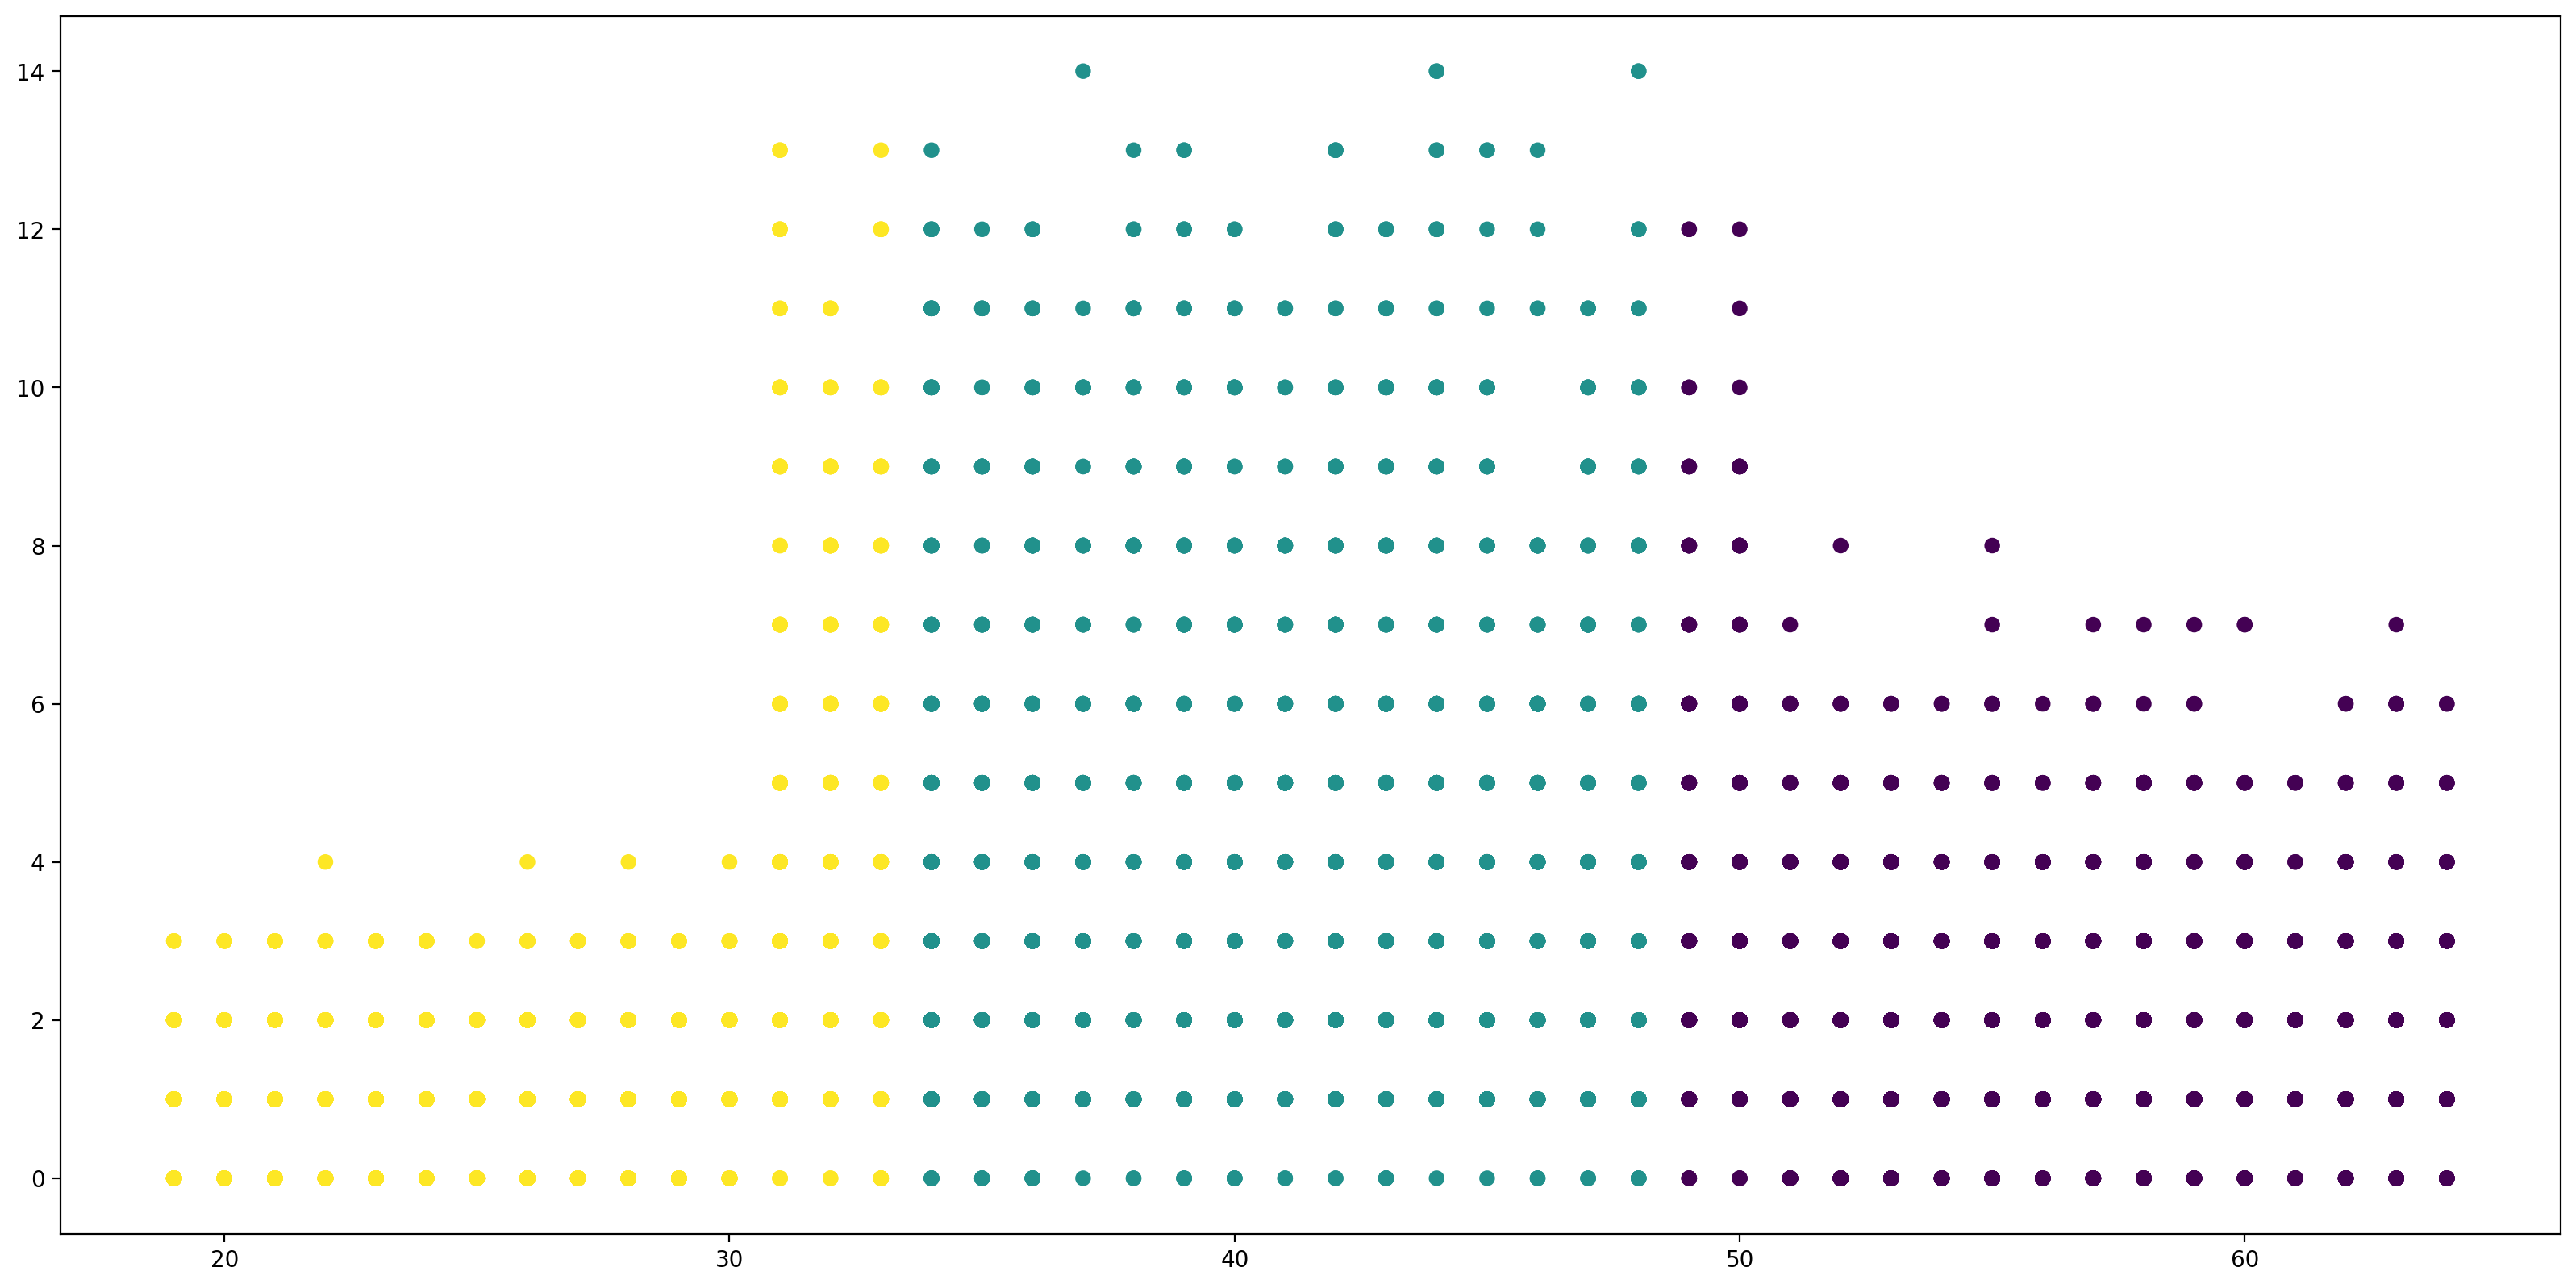

In [22]:
p4.kmeans_graph('age', 'month_buy_rate', customers, 3)

### Pour des raisons de simplicité, on retiendra des tranches d'ages facile à communiquer : 18-30, 31-50, 51+

## Création du dataframe products

**Regroupe les caractéristiques des produits**

1. **id_prod** : clef primaire (unique non nul).
2. **turnover** : chiffre d'affaires du produit.
3. **month_sales_rate** : fréquence des ventes par mois.
4. **categ** : catégorie du produit.

## stucture de base : products_template
ce dataframe va servir à construire les différentes features pour arriver au dataframe final.

In [23]:
transactions = pd.read_csv('./dataset/transactions_normalized.csv', index_col = 'date', parse_dates = True)
products_template = transactions[['id_prod','price','categ']].copy()

### turnover

In [24]:
turnover = products_template[['id_prod','price']].copy()
turnover = turnover.groupby('id_prod').sum()
turnover.columns = ['turnover']
turnover = turnover.round().astype('int')

### month_sales_rate

In [25]:
month_sales_rate = products_template[['id_prod']].copy()

month_sales_rate['count'] = 0

# to compute month's number
nb_month = products_template.resample('M').sum().shape[0]

# to compute sales quantity by id_customer
month_sales_rate = month_sales_rate.groupby('id_prod').count()
month_sales_rate /= nb_month

# to type vector
month_sales_rate.columns = ['month_sales_rate']
month_sales_rate = month_sales_rate.round().astype('int')

### Dataframe products

In [26]:
# to select useful columns
products = transactions[['id_prod','categ']].drop_duplicates().copy()
products = products.set_index('id_prod')

# to merge all features
products = products.merge(turnover, left_index=True, right_index=True)
products = products.merge(month_sales_rate, left_index=True, right_index=True)

# to save dataframe
products = products[['turnover', 'month_sales_rate', 'categ']]
products.to_csv('./dataset/products_preprocessed.csv')